## Libraries/Data required

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [2]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

78


<BR>

## Helper Functions

Here we define a function that lags input variables. There are options for creating a rolling mean, taking the difference between subsequent rows, and dropping NaNs. Feature engineering can of course be extended much further than this.

In [3]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

<br>
Here we define a function that plots a confusion matrix given a prediction and the true values, it can be used both for binary and categorical variables.

In [4]:
def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [5]:
# Create several lagged columns to use as explanatory variables for the model

df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns # View the newly created columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'year',
       'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')

In [6]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [8]:
news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)

In [9]:
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

In [10]:
# country wide news features
news_features = create_news_features(["hunger", 'refugees', 'conflict', 'humanitarian'])

## Predicting using news features

In [11]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
0
0


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- conflict
- humanitarian
- hunger
- refugees

  warnings.warn(message, FutureWarning)


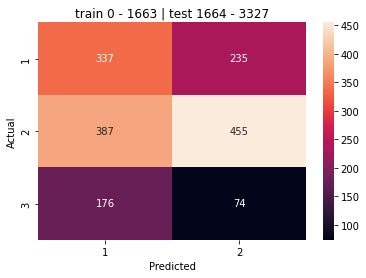

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.37      0.59      0.46       572
           2       0.60      0.54      0.57       842
           3       0.00      0.00      0.00       250

    accuracy                           0.48      1664
   macro avg       0.32      0.38      0.34      1664
weighted avg       0.43      0.48      0.44      1664

Iteration: 0
Iteration: 1
Iteration: 2
0
0


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


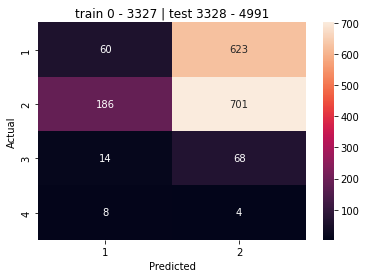

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.22      0.09      0.13       683
           2       0.50      0.79      0.61       887
           3       0.00      0.00      0.00        82
           4       0.00      0.00      0.00        12

    accuracy                           0.46      1664
   macro avg       0.18      0.22      0.19      1664
weighted avg       0.36      0.46      0.38      1664

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
0
0


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


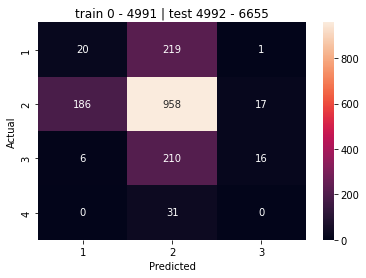

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.09      0.08      0.09       240
           2       0.68      0.83      0.74      1161
           3       0.47      0.07      0.12       232
           4       0.00      0.00      0.00        31

    accuracy                           0.60      1664
   macro avg       0.31      0.24      0.24      1664
weighted avg       0.55      0.60      0.55      1664

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
0
0


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


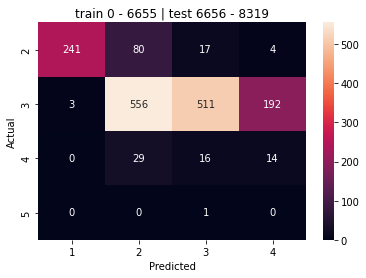

c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.12      0.23      0.16       342
           3       0.94      0.40      0.57      1262
           4       0.07      0.24      0.10        59
           5       0.00      0.00      0.00         1

    accuracy                           0.36      1664
   macro avg       0.22      0.18      0.17      1664
weighted avg       0.74      0.36      0.47      1664

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
0
0


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\missingpy\missforest.py:528: UserWarning: No missing value located; returning original dataset.
  warnings.warn("No missing value located; returning original "


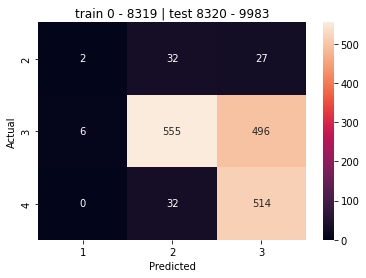

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.05      0.52      0.09        61
           3       0.48      0.47      0.47      1057
           4       0.00      0.00      0.00       546

    accuracy                           0.32      1664
   macro avg       0.13      0.25      0.14      1664
weighted avg       0.31      0.32      0.30      1664

Mean Accuracy: 0.442308
[0.47596153846153844, 0.4573317307692308, 0.5973557692307693, 0.3635817307692308, 0.3173076923076923]


c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Rafi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

<Figure size 432x288 with 0 Axes>

In [12]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings

warnings.filterwarnings(
    action="ignore",
    message="Criterion 'mse'",
)
warnings.filterwarnings(
    action="ignore",
    message="`max_features='auto'`",
)

imputer = MissForest()
label_encoder = LabelEncoder()
df_copy = df.copy()
df_copy.ffill(inplace=True)
df_copy['ipc'] = df_copy['ipc'].astype('int')

X = df_copy.iloc[:, -5:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df_copy[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
accuracy_values = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features (this happens for earlier dates) we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]
    
    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    # Interpolate testing data using the same imputer as for training data
    X_train_imputed = imputer.fit_transform(X_train.values)
    X_test_imputed = imputer.fit_transform(X_test.values)

    print(np.count_nonzero(np.isnan(X_train_imputed)))
    print(np.count_nonzero(np.isnan(X_test_imputed)))

    # Train the RandomForestClassifier
    # number of trees is 100, and  42 is just to initialize random number to make random choices during training
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    results = rf_classifier.fit(X=X_train_imputed, y=np.ravel(y_train))

    rf_classifier.feature_names_in_ = list(X.columns)

    # Predict on the test data
    y_pred = rf_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_values.append(accuracy)

    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']) # Plot confusion matrix

    print (classification_report(y_val,y_pred))


print(f"Mean Accuracy: {np.mean(accuracy_values):.6f}") # Print MAE
print(accuracy_values)

# Why it predicts different values each time?
# In the early years of the data, only ipc 1 and 2 prevail with ipc 3 occurs the least. Thus in the first two iterations it only predicts
# 1 and 2. Then we see more ipc 3 for which it begins to predict in the 3rd iteration. The same can be said about ipc 4. In the final 
# iteration, it focuses on only predicting ipc 2 and 3 which the model thinks it predicts best.

    